<h1 style="color:red">CAB FARE PREDICTION

## Import libraries and load dataset 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
traindf = pd.read_csv('cab.csv', na_values={"pickup_datetime":"43"})
traindf.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


## Data clearning

In [7]:
traindf.isna().sum()

fare_amount          24
pickup_datetime       1
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

In [8]:
traindf.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,10.578384,6.826587,10.575062,6.187087,60.844122
min,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,-73.966838,40.767381,-73.963642,40.768014,2.000000
max,40.766125,401.083332,40.802437,41.366138,5345.000000


### Changing the dtype

In [9]:
traindf['fare_amount'] = pd.to_numeric(traindf['fare_amount'], errors='coerce')

In [10]:
traindf['pickup_datetime'] = pd.to_datetime(traindf['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

### Extract Hour, Date, Day, Month, Year

In [11]:
traindf['Hour'] = traindf['pickup_datetime'].dt.hour
traindf['minute'] = traindf['pickup_datetime'].dt.minute
traindf['date'] = traindf['pickup_datetime'].dt.day
traindf['day'] = traindf['pickup_datetime'].dt.dayofweek
traindf['month'] = traindf['pickup_datetime'].dt.month
traindf['year'] = traindf['pickup_datetime'].dt.year

In [12]:
traindf.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,minute,date,day,month,year
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0,17.0,26.0,15.0,0.0,6.0,2009.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0,16.0,52.0,5.0,1.0,1.0,2010.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0,0.0,35.0,18.0,3.0,8.0,2011.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0,4.0,30.0,21.0,5.0,4.0,2012.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0,7.0,51.0,9.0,1.0,3.0,2010.0


## Handle missing values

#### SimpleImputer

### drop null row from pickup_datetime

In [13]:
traindf.drop(traindf[traindf['pickup_datetime'].isna()].index, inplace=True)

In [14]:
traindf.drop('pickup_datetime', axis=1, inplace=True)

In [15]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#apply it to features

imputer.fit(traindf[['fare_amount','passenger_count']])
traindf[['fare_amount','passenger_count']] = imputer.transform(traindf[['fare_amount','passenger_count']])

In [16]:
traindf.isna().sum()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
Hour                 0
minute               0
date                 0
day                  0
month                0
year                 0
dtype: int64

In [17]:
traindf.shape

(16066, 12)

<AxesSubplot:ylabel='passenger_count'>

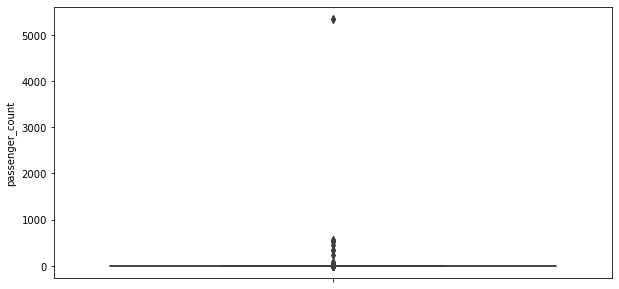

In [18]:
plt.figure(figsize=(10,5))
sns.boxplot(y=traindf['passenger_count'])

<AxesSubplot:ylabel='fare_amount'>

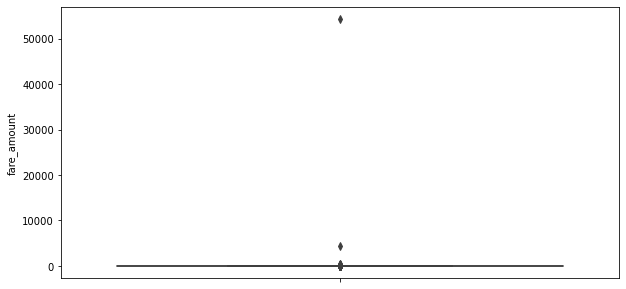

In [19]:
plt.figure(figsize=(10,5))
sns.boxplot(y=traindf['fare_amount'])

## Remove outlier

In [20]:
Q1 = traindf['passenger_count'].quantile(0.25)
Q3 = traindf['passenger_count'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
print('Lower :',lower)
print('Upper :',upper)

Lower : -0.5
Upper : 3.5


#### 1. Remove passenger_count less than zero and with more than 6

In [21]:
traindf['passenger_count'].sort_values(ascending=True).head(10)

13742    0.0
2425     0.0
6575     0.0
5150     0.0
4248     0.0
5058     0.0
9159     0.0
3413     0.0
4114     0.0
15514    0.0
Name: passenger_count, dtype: float64

In [22]:
traindf.drop(traindf[traindf['passenger_count'] > 4 ].index, inplace = True)
traindf.drop(traindf[traindf['passenger_count'] < 0 ].index, inplace = True)
traindf.drop(traindf[traindf['passenger_count'] == 0.12 ].index, inplace = True)
traindf.drop(traindf[traindf['passenger_count'].isna() ].index, inplace = True)

#### 2. Remove fare_amount less than zero and should be less than 454

In [23]:
traindf['fare_amount'].sort_values(ascending=True).head(10)

13032   -3.00
2039    -2.90
2486    -2.50
10002    0.00
2780     0.01
1427     1.14
8596     2.50
503      2.50
8711     2.50
6002     2.50
Name: fare_amount, dtype: float64

In [25]:
traindf.drop(traindf[traindf['fare_amount'] > 150 ].index, inplace = True)
traindf.drop(traindf[traindf['fare_amount'] == 0 ].index, inplace = True)
traindf.drop(traindf[traindf['fare_amount'].isna() ].index, inplace = True)

#### 3. Pickup and dropoff latitude should be (-90 to 90 )

In [26]:
traindf.drop(traindf[traindf['pickup_latitude'] > 90].index, inplace=True)
traindf.drop(traindf[traindf['pickup_latitude'] < -90].index, inplace=True)
traindf.drop(traindf[traindf['dropoff_latitude'] > 90].index, inplace=True)
traindf.drop(traindf[traindf['dropoff_latitude'] < -90].index, inplace=True) 

#### 4. Pickup and dropoff longtitude should be ( -180 to 180 )

In [27]:

traindf.drop(traindf[traindf['pickup_longitude'] > 180].index, inplace=True)
traindf.drop(traindf[traindf['pickup_longitude'] < -180].index, inplace=True)
traindf.drop(traindf[traindf['dropoff_longitude'] > 180].index, inplace=True)
traindf.drop(traindf[traindf['dropoff_longitude'] < -180].index, inplace=True) 

In [28]:
traindf.shape

(14690, 12)

In [29]:
traindf.isna().sum()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
Hour                 0
minute               0
date                 0
day                  0
month                0
year                 0
dtype: int64

### Calculate distance using Haversion formulas

In [30]:
from math import *

def haversine(a):
    lon1=a[0]
    lat1=a[1]
    lon2=a[2]
    lat2=a[3]
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c =  2 * asin(sqrt(a))
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [31]:
traindf['distance'] = traindf[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)

In [32]:
traindf.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1, inplace=True)

In [33]:
traindf['Hour'] = traindf['Hour'].astype('int64')
traindf['minute'] = traindf['minute'].astype('int64')
traindf['date'] = traindf['date'].astype('int64')
traindf['day'] = traindf['day'].astype('int64')
traindf['month'] = traindf['month'].astype('int64')
traindf['year'] = traindf['year'].astype('int64')

In [34]:
traindf.head()

,fare_amount,passenger_count,Hour,minute,date,day,month,year,distance
0,4.5,1.0,17,26,15,0,6,2009,1.030764
1,16.9,1.0,16,52,5,1,1,2010,8.450134
2,5.7,2.0,0,35,18,3,8,2011,1.389525
3,7.7,1.0,4,30,21,5,4,2012,2.799270
4,5.3,1.0,7,51,9,1,3,2010,1.999157


#### Distance should be positive and less than 130 Km.

In [35]:
traindf['distance'].sort_values(ascending=True).head(10)

1542     0.0
8135     0.0
8130     0.0
8123     0.0
8109     0.0
13446    0.0
1397     0.0
8068     0.0
8063     0.0
1419     0.0
Name: distance, dtype: float64

In [36]:
traindf.drop(traindf[traindf['distance'] >= 130].index, inplace=True)
traindf.drop(traindf[traindf['distance'] <= 0 ].index, inplace=True)

In [37]:
#traindf.drop(traindf[traindf['distance'].isna() ].index, inplace=True)

In [38]:
traindf.head()

,fare_amount,passenger_count,Hour,minute,date,day,month,year,distance
0,4.5,1.0,17,26,15,0,6,2009,1.030764
1,16.9,1.0,16,52,5,1,1,2010,8.450134
2,5.7,2.0,0,35,18,3,8,2011,1.389525
3,7.7,1.0,4,30,21,5,4,2012,2.799270
4,5.3,1.0,7,51,9,1,3,2010,1.999157


### EDA

<AxesSubplot:ylabel='passenger_count'>

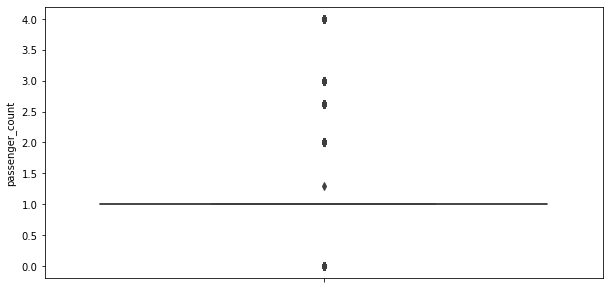

In [39]:
plt.figure(figsize=(10,5))
sns.boxplot(y=traindf['passenger_count'])

<AxesSubplot:ylabel='fare_amount'>

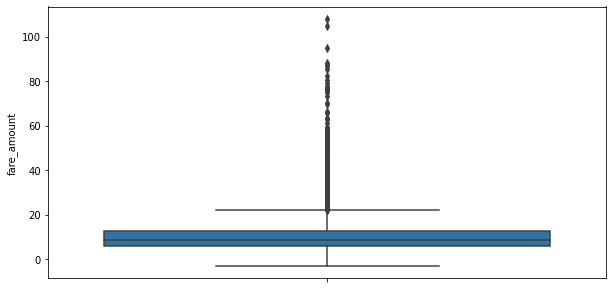

In [40]:
plt.figure(figsize=(10,5))
sns.boxplot(y=traindf['fare_amount'])

<AxesSubplot:ylabel='distance'>

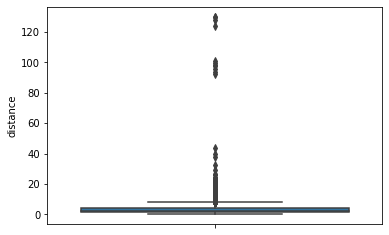

In [41]:
sns.boxplot(y=traindf['distance'])

In [42]:
traindf.describe()

,fare_amount,passenger_count,Hour,minute,date,day,month,year,distance
count,14244.000000,14244.000000,14244.000000,14244.000000,14244.000000,14244.000000,14244.000000,14244.000000,14244.000000
mean,11.310145,1.320604,13.490312,29.746069,15.668211,3.030820,6.264462,2011.739890,3.451184
std,9.434057,0.675145,6.514905,17.288493,8.685281,1.971422,3.444883,1.870919,4.674488
min,-3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2009.000000,0.000111
25%,6.000000,1.000000,9.000000,15.000000,8.000000,1.000000,3.000000,2010.000000,1.277104
50%,8.500000,1.000000,14.000000,30.000000,16.000000,3.000000,6.000000,2012.000000,2.196772
75%,12.500000,1.000000,19.000000,45.000000,23.000000,5.000000,9.000000,2013.000000,3.935514
max,108.000000,4.000000,23.000000,59.000000,31.000000,6.000000,12.000000,2015.000000,129.950482


In [43]:
traindf['passenger_count'] = traindf['passenger_count'].astype('int64')

### Train Test Split

In [44]:
traindf.head()

,fare_amount,passenger_count,Hour,minute,date,day,month,year,distance
0,4.5,1,17,26,15,0,6,2009,1.030764
1,16.9,1,16,52,5,1,1,2010,8.450134
2,5.7,2,0,35,18,3,8,2011,1.389525
3,7.7,1,4,30,21,5,4,2012,2.799270
4,5.3,1,7,51,9,1,3,2010,1.999157


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(traindf.drop('fare_amount', axis=1),
                                                   traindf['fare_amount'], test_size=0.4, random_state = 42)

### Model selection

In [46]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=250, criterion='mae')

In [47]:
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


RandomForestRegressor(criterion='mae', n_estimators=250)

In [48]:
predicts = model.predict(X_test)

In [49]:
model.score(X_train, y_train)

0.9683915001663908

### Model Evaluation

In [50]:
from sklearn.metrics import r2_score

score=r2_score(y_test,predicts)
score

0.8072250545669044

In [51]:
from sklearn.metrics import mean_squared_error

RMSE = np.sqrt(mean_squared_error(y_test, predicts))
RMSE

4.1315631167440605